### Instead of hardcoded thresholds, use a more flexible approach that adapts to the data and model performance:
* Machine Learning Techniques:
    - Employ techniques like hyperparameter tuning and feature engineering to improve model performance and reduce error.
* Statistical Hypothesis Testing:
    - Use hypothesis testing to compare the performance of your model to a baseline or a benchmark model.
* Percentile-Based Thresholds:
    - Calculate percentiles of the error distribution to set dynamic thresholds. For example, you might define "excellent" as the top 10% of models in terms of MSE.

In [1]:
import sys
sys.path.append("/Users/shaneypeterson/Desktop/2024.06.27_-_Data_Science/Modules")

In [2]:
import stocks as st
import numpy as np
import pandas as pd

In [3]:
st = st.Stocks()

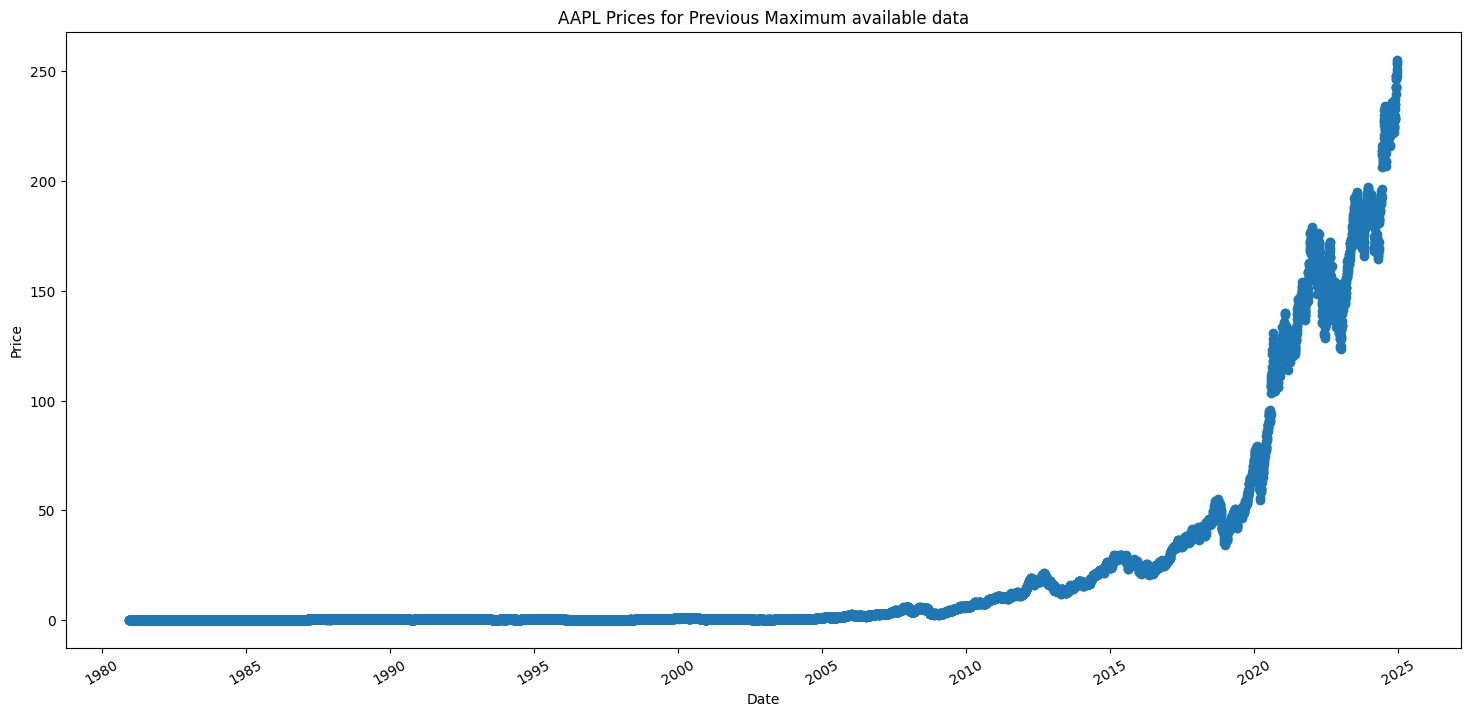

Closing price as of 2024-12-23: $255.27
The percentage change over previous Maximum available data is 258180%
Dividends total $8.77
Stock Splits total $17.0
'Capital Gains' not found in data


In [17]:
df = st.stats_generator('aapl')

In [18]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1980-12-12 00:00:00-05:00,0.098834,0.099264,0.098834,0.098834,469033600,0.0,0.0
1,1980-12-15 00:00:00-05:00,0.094108,0.094108,0.093678,0.093678,175884800,0.0,0.0
2,1980-12-16 00:00:00-05:00,0.087232,0.087232,0.086802,0.086802,105728000,0.0,0.0
3,1980-12-17 00:00:00-05:00,0.088951,0.089381,0.088951,0.088951,86441600,0.0,0.0
4,1980-12-18 00:00:00-05:00,0.091530,0.091959,0.091530,0.091530,73449600,0.0,0.0


In [19]:
# remove timezone
import pandas as pd

df['Date'] = pd.to_datetime(df['Date']).dt.date

In [20]:
df_train = df[['Date' ,'Close']]
df_train = df_train.rename(columns={'Date': 'ds', 'Close': 'y'})

In [21]:
period = 365

In [22]:
from prophet import Prophet

m = Prophet()
m.fit(df_train)
future = m.make_future_dataframe(periods=period)
forecast = m.predict(future)

05:09:29 - cmdstanpy - INFO - Chain [1] start processing
05:09:32 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def get_model_accuracy(df_train, forecast):
    # Extract actual and predicted values
    y_true = df_train['y'][-period:]
    y_pred = forecast['yhat'][-period:]

    # Calculate accuracy metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Create a DataFrame for the metrics
    metrics_df = pd.DataFrame({
        'Mean Absolute Error': mae,
        'Mean Absolute Percentage Error': mape,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse
        },
        index=[0])
    
    return metrics_df

In [24]:
get_model_accuracy(df_train, forecast)

,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,23.025373,0.126057,769.345264,27.737074


### Grid Search

In [25]:
# Define hyperparameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 1],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10]
}

# Perform grid search
best_params = None
best_rmse = float('inf')

for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
    for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
        # Create and fit the model
        m = Prophet(
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale
        )
        m.fit(df_train)

        # Make predictions
        future = m.make_future_dataframe(periods=period) 
        forecast = m.predict(future)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(df_train['y'][-period:], forecast['yhat'][-period:]))

        # Update best parameters if necessary
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = {
                'changepoint_prior_scale': changepoint_prior_scale,
                'seasonality_prior_scale': seasonality_prior_scale
            }

05:09:38 - cmdstanpy - INFO - Chain [1] start processing
05:09:39 - cmdstanpy - INFO - Chain [1] done processing
05:09:40 - cmdstanpy - INFO - Chain [1] start processing
05:09:41 - cmdstanpy - INFO - Chain [1] done processing
05:09:42 - cmdstanpy - INFO - Chain [1] start processing
05:09:43 - cmdstanpy - INFO - Chain [1] done processing
05:09:44 - cmdstanpy - INFO - Chain [1] start processing
05:09:46 - cmdstanpy - INFO - Chain [1] done processing
05:09:47 - cmdstanpy - INFO - Chain [1] start processing
05:09:49 - cmdstanpy - INFO - Chain [1] done processing
05:09:50 - cmdstanpy - INFO - Chain [1] start processing
05:09:52 - cmdstanpy - INFO - Chain [1] done processing
05:09:53 - cmdstanpy - INFO - Chain [1] start processing
05:09:55 - cmdstanpy - INFO - Chain [1] done processing
05:09:56 - cmdstanpy - INFO - Chain [1] start processing
05:09:57 - cmdstanpy - INFO - Chain [1] done processing
05:09:58 - cmdstanpy - INFO - Chain [1] start processing
05:10:01 - cmdstanpy - INFO - Chain [1]

In [26]:
print(f"Best parameters: {best_params}") 
print(f"Best RMSE: {best_rmse}")

Best parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1}
Best RMSE: 20.333967754417436


In [27]:
def implement_tuning():
    m = Prophet(
            changepoint_prior_scale=best_params['changepoint_prior_scale'],
            seasonality_prior_scale=best_params['seasonality_prior_scale']
        )
    m.fit(df_train)

    # Make predictions
    future = m.make_future_dataframe(periods=period) 
    forecast = m.predict(future)

    return forecast

In [28]:
forecast = implement_tuning()

05:10:30 - cmdstanpy - INFO - Chain [1] start processing
05:10:30 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
get_model_accuracy(df_train, forecast)

,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,17.860999,0.093805,413.470245,20.333968


### Random Search

In [30]:
from hyperopt import fmin, tpe, hp

In [31]:
# Define hyperparameter ranges
param_dist = {
    'changepoint_prior_scale': np.random.uniform(0.001, 1, 10),
    'seasonality_prior_scale': np.random.uniform(0.01, 10, 10)
}

# Number of iterations for random search
n_iter = 20 

# Perform random search
best_params = None
best_rmse = float('inf')

for _ in range(n_iter):
    # Sample random hyperparameters
    changepoint_prior_scale = param_dist['changepoint_prior_scale'][np.random.randint(10)]
    seasonality_prior_scale = param_dist['seasonality_prior_scale'][np.random.randint(10)]

    # Create and fit the model
    m = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale
    )
    m.fit(df_train)

    # Make predictions
    future = m.make_future_dataframe(periods=period) 
    forecast = m.predict(future)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(df_train['y'][-period:], forecast['yhat'][-period:]))

    # Update best parameters if necessary
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {
            'changepoint_prior_scale': changepoint_prior_scale,
            'seasonality_prior_scale': seasonality_prior_scale
        }

05:13:14 - cmdstanpy - INFO - Chain [1] start processing
05:13:17 - cmdstanpy - INFO - Chain [1] done processing
05:13:18 - cmdstanpy - INFO - Chain [1] start processing
05:13:21 - cmdstanpy - INFO - Chain [1] done processing
05:13:22 - cmdstanpy - INFO - Chain [1] start processing
05:13:24 - cmdstanpy - INFO - Chain [1] done processing
05:13:25 - cmdstanpy - INFO - Chain [1] start processing
05:13:28 - cmdstanpy - INFO - Chain [1] done processing
05:13:29 - cmdstanpy - INFO - Chain [1] start processing
05:13:32 - cmdstanpy - INFO - Chain [1] done processing
05:13:33 - cmdstanpy - INFO - Chain [1] start processing
05:13:36 - cmdstanpy - INFO - Chain [1] done processing
05:13:37 - cmdstanpy - INFO - Chain [1] start processing
05:13:39 - cmdstanpy - INFO - Chain [1] done processing
05:13:40 - cmdstanpy - INFO - Chain [1] start processing
05:13:43 - cmdstanpy - INFO - Chain [1] done processing
05:13:44 - cmdstanpy - INFO - Chain [1] start processing
05:13:46 - cmdstanpy - INFO - Chain [1]

In [32]:
print(f"Best parameters: {best_params}") 
print(f"Best RMSE: {best_rmse}")

Best parameters: {'changepoint_prior_scale': np.float64(0.03401007624859016), 'seasonality_prior_scale': np.float64(8.846652214095078)}
Best RMSE: 27.46853895355753


In [33]:
forecast = implement_tuning()

05:14:28 - cmdstanpy - INFO - Chain [1] start processing
05:14:30 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
get_model_accuracy(df_train, forecast)

,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,22.78529,0.124726,754.520632,27.468539


### Bayesian Optimization

In [35]:
from hyperopt import fmin, tpe, hp

# Define objective function
def objective(params):
    changepoint_prior_scale = params['changepoint_prior_scale']
    seasonality_prior_scale = params['seasonality_prior_scale']

    # Create and fit the model
    m = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale
    )
    m.fit(df_train)

    # Make predictions
    future = m.make_future_dataframe(periods=period) 
    forecast = m.predict(future)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(df_train['y'][-period:], forecast['yhat'][-period:]))

    return rmse

# Define search space
space = {
    'changepoint_prior_scale': hp.loguniform('changepoint_prior_scale', np.log(0.001), np.log(1)),
    'seasonality_prior_scale': hp.loguniform('seasonality_prior_scale', np.log(0.01), np.log(10))
}

# Perform Bayesian optimization
best = fmin(fn=objective, 
           space=space, 
           algo=tpe.suggest, 
           max_evals=50)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

05:16:29 - cmdstanpy - INFO - Chain [1] start processing
05:16:32 - cmdstanpy - INFO - Chain [1] done processing


  2%|▏         | 1/50 [00:04<03:37,  4.44s/trial, best loss: 27.81676644813619]

05:16:33 - cmdstanpy - INFO - Chain [1] start processing
05:16:35 - cmdstanpy - INFO - Chain [1] done processing


  4%|▍         | 2/50 [00:07<02:53,  3.62s/trial, best loss: 27.81676644813619]

05:16:36 - cmdstanpy - INFO - Chain [1] start processing
05:16:37 - cmdstanpy - INFO - Chain [1] done processing


  6%|▌         | 3/50 [00:09<02:13,  2.85s/trial, best loss: 23.667410572255147]

05:16:38 - cmdstanpy - INFO - Chain [1] start processing
05:16:40 - cmdstanpy - INFO - Chain [1] done processing


  8%|▊         | 4/50 [00:12<02:16,  2.96s/trial, best loss: 23.667410572255147]

05:16:41 - cmdstanpy - INFO - Chain [1] start processing
05:16:44 - cmdstanpy - INFO - Chain [1] done processing


 10%|█         | 5/50 [00:16<02:31,  3.37s/trial, best loss: 23.667410572255147]

05:16:45 - cmdstanpy - INFO - Chain [1] start processing
05:16:48 - cmdstanpy - INFO - Chain [1] done processing


 12%|█▏        | 6/50 [00:20<02:30,  3.42s/trial, best loss: 23.667410572255147]

05:16:49 - cmdstanpy - INFO - Chain [1] start processing
05:16:49 - cmdstanpy - INFO - Chain [1] done processing


 14%|█▍        | 7/50 [00:21<02:03,  2.88s/trial, best loss: 23.414198643962283]

05:16:50 - cmdstanpy - INFO - Chain [1] start processing
05:16:52 - cmdstanpy - INFO - Chain [1] done processing


 16%|█▌        | 8/50 [00:24<01:59,  2.84s/trial, best loss: 23.414198643962283]

05:16:53 - cmdstanpy - INFO - Chain [1] start processing
05:16:56 - cmdstanpy - INFO - Chain [1] done processing


 18%|█▊        | 9/50 [00:28<02:10,  3.18s/trial, best loss: 23.414198643962283]

05:16:57 - cmdstanpy - INFO - Chain [1] start processing
05:16:58 - cmdstanpy - INFO - Chain [1] done processing


 20%|██        | 10/50 [00:30<01:52,  2.80s/trial, best loss: 23.29794644952056]

05:16:59 - cmdstanpy - INFO - Chain [1] start processing
05:17:03 - cmdstanpy - INFO - Chain [1] done processing


 22%|██▏       | 11/50 [00:35<02:10,  3.34s/trial, best loss: 23.29794644952056]

05:17:04 - cmdstanpy - INFO - Chain [1] start processing
05:17:05 - cmdstanpy - INFO - Chain [1] done processing


 24%|██▍       | 12/50 [00:37<01:51,  2.95s/trial, best loss: 23.29794644952056]

05:17:06 - cmdstanpy - INFO - Chain [1] start processing
05:17:07 - cmdstanpy - INFO - Chain [1] done processing


 26%|██▌       | 13/50 [00:39<01:38,  2.65s/trial, best loss: 22.356532258283888]

05:17:08 - cmdstanpy - INFO - Chain [1] start processing
05:17:09 - cmdstanpy - INFO - Chain [1] done processing


 28%|██▊       | 14/50 [00:41<01:28,  2.45s/trial, best loss: 22.356532258283888]

05:17:10 - cmdstanpy - INFO - Chain [1] start processing
05:17:13 - cmdstanpy - INFO - Chain [1] done processing


 30%|███       | 15/50 [00:45<01:43,  2.95s/trial, best loss: 22.356532258283888]

05:17:14 - cmdstanpy - INFO - Chain [1] start processing
05:17:17 - cmdstanpy - INFO - Chain [1] done processing


 32%|███▏      | 16/50 [00:49<01:52,  3.32s/trial, best loss: 22.356532258283888]

05:17:18 - cmdstanpy - INFO - Chain [1] start processing
05:17:21 - cmdstanpy - INFO - Chain [1] done processing


 34%|███▍      | 17/50 [00:53<01:53,  3.44s/trial, best loss: 22.356532258283888]

05:17:22 - cmdstanpy - INFO - Chain [1] start processing
05:17:24 - cmdstanpy - INFO - Chain [1] done processing


 36%|███▌      | 18/50 [00:56<01:52,  3.51s/trial, best loss: 22.356532258283888]

05:17:25 - cmdstanpy - INFO - Chain [1] start processing
05:17:29 - cmdstanpy - INFO - Chain [1] done processing


 38%|███▊      | 19/50 [01:01<01:55,  3.72s/trial, best loss: 22.356532258283888]

05:17:30 - cmdstanpy - INFO - Chain [1] start processing
05:17:33 - cmdstanpy - INFO - Chain [1] done processing


 40%|████      | 20/50 [01:05<01:56,  3.87s/trial, best loss: 22.356532258283888]

05:17:34 - cmdstanpy - INFO - Chain [1] start processing
05:17:35 - cmdstanpy - INFO - Chain [1] done processing


 42%|████▏     | 21/50 [01:07<01:36,  3.34s/trial, best loss: 22.256916680986187]

05:17:36 - cmdstanpy - INFO - Chain [1] start processing
05:17:37 - cmdstanpy - INFO - Chain [1] done processing


 44%|████▍     | 22/50 [01:09<01:22,  2.94s/trial, best loss: 20.313876854722373]

05:17:38 - cmdstanpy - INFO - Chain [1] start processing
05:17:40 - cmdstanpy - INFO - Chain [1] done processing


 46%|████▌     | 23/50 [01:12<01:23,  3.10s/trial, best loss: 20.313876854722373]

05:17:41 - cmdstanpy - INFO - Chain [1] start processing
05:17:42 - cmdstanpy - INFO - Chain [1] done processing


 48%|████▊     | 24/50 [01:14<01:13,  2.81s/trial, best loss: 20.313876854722373]

05:17:44 - cmdstanpy - INFO - Chain [1] start processing
05:17:45 - cmdstanpy - INFO - Chain [1] done processing


 50%|█████     | 25/50 [01:17<01:06,  2.64s/trial, best loss: 20.313876854722373]

05:17:46 - cmdstanpy - INFO - Chain [1] start processing
05:17:48 - cmdstanpy - INFO - Chain [1] done processing


 52%|█████▏    | 26/50 [01:20<01:08,  2.87s/trial, best loss: 20.313876854722373]

05:17:49 - cmdstanpy - INFO - Chain [1] start processing
05:17:50 - cmdstanpy - INFO - Chain [1] done processing


 54%|█████▍    | 27/50 [01:22<00:58,  2.56s/trial, best loss: 20.313876854722373]

05:17:51 - cmdstanpy - INFO - Chain [1] start processing
05:17:52 - cmdstanpy - INFO - Chain [1] done processing


 56%|█████▌    | 28/50 [01:24<00:51,  2.33s/trial, best loss: 20.313876854722373]

05:17:53 - cmdstanpy - INFO - Chain [1] start processing
05:17:54 - cmdstanpy - INFO - Chain [1] done processing


 58%|█████▊    | 29/50 [01:26<00:50,  2.41s/trial, best loss: 20.313876854722373]

05:17:55 - cmdstanpy - INFO - Chain [1] start processing
05:17:59 - cmdstanpy - INFO - Chain [1] done processing


 60%|██████    | 30/50 [01:31<00:59,  2.95s/trial, best loss: 20.313876854722373]

05:18:00 - cmdstanpy - INFO - Chain [1] start processing
05:18:00 - cmdstanpy - INFO - Chain [1] done processing


 62%|██████▏   | 31/50 [01:32<00:50,  2.64s/trial, best loss: 20.313876854722373]

05:18:02 - cmdstanpy - INFO - Chain [1] start processing
05:18:02 - cmdstanpy - INFO - Chain [1] done processing


 64%|██████▍   | 32/50 [01:34<00:43,  2.43s/trial, best loss: 20.313876854722373]

05:18:03 - cmdstanpy - INFO - Chain [1] start processing
05:18:06 - cmdstanpy - INFO - Chain [1] done processing


 66%|██████▌   | 33/50 [01:38<00:45,  2.70s/trial, best loss: 20.313876854722373]

05:18:07 - cmdstanpy - INFO - Chain [1] start processing
05:18:08 - cmdstanpy - INFO - Chain [1] done processing


 68%|██████▊   | 34/50 [01:40<00:41,  2.59s/trial, best loss: 20.313876854722373]

05:18:09 - cmdstanpy - INFO - Chain [1] start processing
05:18:12 - cmdstanpy - INFO - Chain [1] done processing


 70%|███████   | 35/50 [01:44<00:44,  2.95s/trial, best loss: 20.313876854722373]

05:18:13 - cmdstanpy - INFO - Chain [1] start processing
05:18:16 - cmdstanpy - INFO - Chain [1] done processing


 72%|███████▏  | 36/50 [01:48<00:45,  3.28s/trial, best loss: 20.313876854722373]

05:18:17 - cmdstanpy - INFO - Chain [1] start processing
05:18:18 - cmdstanpy - INFO - Chain [1] done processing


 74%|███████▍  | 37/50 [01:50<00:38,  2.93s/trial, best loss: 20.313876854722373]

05:18:19 - cmdstanpy - INFO - Chain [1] start processing
05:18:21 - cmdstanpy - INFO - Chain [1] done processing


 76%|███████▌  | 38/50 [01:53<00:36,  3.04s/trial, best loss: 20.313876854722373]

05:18:22 - cmdstanpy - INFO - Chain [1] start processing
05:18:23 - cmdstanpy - INFO - Chain [1] done processing


 78%|███████▊  | 39/50 [01:55<00:29,  2.69s/trial, best loss: 20.313876854722373]

05:18:24 - cmdstanpy - INFO - Chain [1] start processing
05:18:27 - cmdstanpy - INFO - Chain [1] done processing


 80%|████████  | 40/50 [01:59<00:28,  2.90s/trial, best loss: 20.313876854722373]

05:18:28 - cmdstanpy - INFO - Chain [1] start processing
05:18:28 - cmdstanpy - INFO - Chain [1] done processing


 82%|████████▏ | 41/50 [02:00<00:23,  2.58s/trial, best loss: 20.313876854722373]

05:18:29 - cmdstanpy - INFO - Chain [1] start processing
05:18:30 - cmdstanpy - INFO - Chain [1] done processing


 84%|████████▍ | 42/50 [02:02<00:18,  2.36s/trial, best loss: 20.15680911322631] 

05:18:31 - cmdstanpy - INFO - Chain [1] start processing
05:18:32 - cmdstanpy - INFO - Chain [1] done processing


 86%|████████▌ | 43/50 [02:04<00:15,  2.21s/trial, best loss: 20.15680911322631]

05:18:33 - cmdstanpy - INFO - Chain [1] start processing
05:18:35 - cmdstanpy - INFO - Chain [1] done processing


 88%|████████▊ | 44/50 [02:08<00:15,  2.57s/trial, best loss: 20.15680911322631]

05:18:37 - cmdstanpy - INFO - Chain [1] start processing
05:18:37 - cmdstanpy - INFO - Chain [1] done processing


 90%|█████████ | 45/50 [02:09<00:11,  2.38s/trial, best loss: 20.15680911322631]

05:18:39 - cmdstanpy - INFO - Chain [1] start processing
05:18:39 - cmdstanpy - INFO - Chain [1] done processing


 92%|█████████▏| 46/50 [02:11<00:08,  2.22s/trial, best loss: 20.15680911322631]

05:18:40 - cmdstanpy - INFO - Chain [1] start processing
05:18:42 - cmdstanpy - INFO - Chain [1] done processing


 94%|█████████▍| 47/50 [02:14<00:06,  2.25s/trial, best loss: 20.15680911322631]

05:18:43 - cmdstanpy - INFO - Chain [1] start processing
05:18:44 - cmdstanpy - INFO - Chain [1] done processing


 96%|█████████▌| 48/50 [02:16<00:04,  2.15s/trial, best loss: 20.15680911322631]

05:18:45 - cmdstanpy - INFO - Chain [1] start processing
05:18:47 - cmdstanpy - INFO - Chain [1] done processing


 98%|█████████▊| 49/50 [02:19<00:02,  2.47s/trial, best loss: 20.15680911322631]

05:18:48 - cmdstanpy - INFO - Chain [1] start processing
05:18:51 - cmdstanpy - INFO - Chain [1] done processing


100%|██████████| 50/50 [02:23<00:00,  2.87s/trial, best loss: 20.15680911322631]


In [36]:
# Print best parameters
print(f"Best parameters: {best}")

Best parameters: {'changepoint_prior_scale': np.float64(0.0010514768372711842), 'seasonality_prior_scale': np.float64(0.031151403303546012)}


In [37]:
forecast = implement_tuning()

05:18:52 - cmdstanpy - INFO - Chain [1] start processing
05:18:55 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
get_model_accuracy(df_train, forecast)

,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,22.78529,0.124726,754.520632,27.468539


### Grid Search seems to be the most effective and fastest so far. lets try on a few different tickers